In [1]:

import geopandas as gpd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import numpy as np
import statsmodels.api as sm
from scipy.ndimage import gaussian_filter1d

from utils.plotting import savefig, load_default_mpl_config
from utils.data import load_xval
from utils.shapefiles import get_shapefile
from config import get_path_dict

load_default_mpl_config()

paths = get_path_dict()

ds = load_xval(
    xval_dir=paths['runs'] / 'staticall_allbasins_sqrttrans/LSTM/xval/',
    sources=0).sel(time=slice('1962', '2023'))
prevah, _ = get_shapefile(source='prevah', datapath=paths['data'])


def add_data(
        da: xr.DataArray,
        gd: gpd.GeoDataFrame, 
        new_col='da_var',
        allow_missing_id: bool = False) -> gpd.GeoDataFrame:

    da = da.load()

    gd[new_col] = da.sel(station=gd.OID.values).values

    return gd


def digitize(x: xr.DataArray) -> xr.DataArray:
    num_bins = 13
    q = x.sel(time=slice('1971', '2000')).quantile(np.linspace(0.0, 1.0, num_bins), dim='time')
    # q = xr.apply_ufunc(np.digitize, x, q.values, input_core_dims=[('time')], vectorize = True)
    r = xr.apply_ufunc(
        np.digitize, x, q,
        input_core_dims=[['time'], ['quantile']],
        output_core_dims=[['time']], vectorize=True) / num_bins

    return r


def plot_linreg(x, y, color, ax, **kwargs):
    sort_indices = np.argsort(x)
    x = x[sort_indices]
    y = y[sort_indices]

    X = sm.add_constant(x)
    ols_model = sm.OLS(y, X)
    est = ols_model.fit()
    out = est.conf_int(alpha=0.05, cols=None)

    y_pred = est.predict(X)
    x_pred = x
    ax.plot(x_pred, y_pred, color=color, zorder=100, **kwargs)


    return est


def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def add_interval(ax, xdata, ydata, caps="  ", color='0.4'):
    line = ax.add_line(mpl.lines.Line2D(xdata, ydata, color=color, solid_capstyle='butt'))
    anno_args = {
        'ha': 'center',
        'va': 'center',
        'size': 12,
        'color': line.get_color()
    }
    a0 = ax.annotate(caps[0], xy=(xdata[0], ydata[0]), **anno_args)
    a1 = ax.annotate(caps[1], xy=(xdata[1], ydata[1]), **anno_args)
    return (line,(a0,a1))


qmm_year = ds.Qmm_mod.resample(time='1Y').sum('time').median('cv').compute()
qmm_year_ref = qmm_year.sel(time=slice('1971', '2000')).mean('time').compute()
qmm_year_ano = (qmm_year - qmm_year_ref).compute()

ERROR 1: PROJ: proj_create_from_database: Open of /home/kraftb/.conda/envs/machflow/share/proj failed
/home/kraftb/.conda/envs/machflow/lib/python3.10/site-packages/xarray/core/groupby.py:668: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


In [ ]:
ds = ds.median('cv').compute()
dsa = (ds * ds.area).sum('station').compute()

In [ ]:
dsa.Qmm_mod.groupby('time.year')

DataArrayGroupBy, grouped over 'year'
62 groups with labels 1962, 1963, 1964, ..., 2022, 2023.

(np.float64(0.0), np.float64(0.0), np.float64(0.5), np.float64(1.0))
(np.float64(0.0), np.float64(0.4725490196078431), np.float64(1.0), np.float64(1.0))
(np.float64(0.43959519291587595), np.float64(1.0), np.float64(0.5281467425679949), np.float64(1.0))
(np.float64(1.0), np.float64(0.6688453159041396), np.float64(0.0), np.float64(1.0))
(np.float64(0.6247771836007131), np.float64(0.0), np.float64(0.0), np.float64(1.0))
(np.float64(0.5), np.float64(0.0), np.float64(0.0), np.float64(1.0))
(np.float64(0.5), np.float64(0.0), np.float64(0.0), np.float64(1.0))
(np.float64(0.5), np.float64(0.0), np.float64(0.0), np.float64(1.0))
(np.float64(0.5), np.float64(0.0), np.float64(0.0), np.float64(1.0))
(np.float64(0.5), np.float64(0.0), np.float64(0.0), np.float64(1.0))
(np.float64(0.5), np.float64(0.0), np.float64(0.0), np.float64(1.0))
(np.float64(0.5), np.float64(0.0), np.float64(0.0), np.float64(1.0))
(np.float64(0.5), np.float64(0.0), np.float64(0.0), np.float64(1.0))
(np.float64(0.5), np.float6

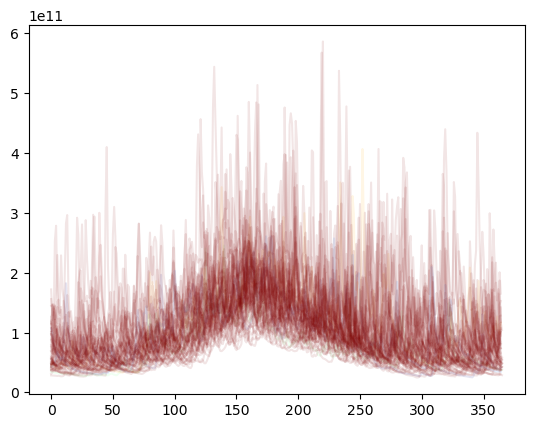

In [ ]:
fig, ax = plt.subplots()

start_year = dsa.time[0].dt.year.item()
end_year =  dsa.time[-1].dt.year.item() + 1
colors = plt.cm.rainbow(np.linspace(0, 1, end_year - start_year))

for i, year in enumerate(range(start_year, end_year)):
    c = plt.colormaps['jet']((end_year - start_year) /255 * i)
    print(c)
    plt.plot(dsa.Qmm_mod.sel(time=str(year)), alpha=0.1, color=c)

In [40]:
end_year - start_year

62

In [42]:
plt.colormaps['jet'](255 / (end_year - start_year) * i)

(np.float64(0.5), np.float64(0.0), np.float64(0.0), np.float64(1.0))

In [43]:
255 / (end_year - start_year) * i

250.88709677419357

In [49]:
n = 2
color = plt.cm.rainbow(np.linspace(0, 1, n))
color

array([[5.0000000e-01, 0.0000000e+00, 1.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 1.2246468e-16, 6.1232340e-17, 1.0000000e+00]])